In [2]:
import pandas as pd
import matplotlib.pyplot as plt
# 新版已經改成獨立的 mplfinance 套件
# import matplotlib.finance as mpf

import mplfinance as mpf

In [3]:
# 讀入 data/tsla_df_dummies.csv
tsla_df = pd.read_csv("data/tsla_df_dummies.csv", index_col=0)

# 將 index 轉成 datetime
tsla_df.index = pd.to_datetime(tsla_df.index)

# 確認排序（很重要）
tsla_df = tsla_df.sort_index()

tsla_df.head()

,Close,High,Low,Open,Volume,date_weekday,netChangeRatio,positive
Date,,,,,,,,
2020-01-02,28.684000,28.713333,28.114000,28.299999,142981500,3,NaN,0
2020-01-03,29.534000,30.266666,29.128000,29.366667,266677500,4,2.963326,1
2020-01-06,30.102667,30.104000,29.333332,29.364668,151995000,0,1.925464,1
2020-01-07,31.270666,31.441999,30.224001,30.760000,268231500,1,3.880052,1
2020-01-08,32.809334,33.232666,31.215334,31.580000,467164500,2,4.920483,1


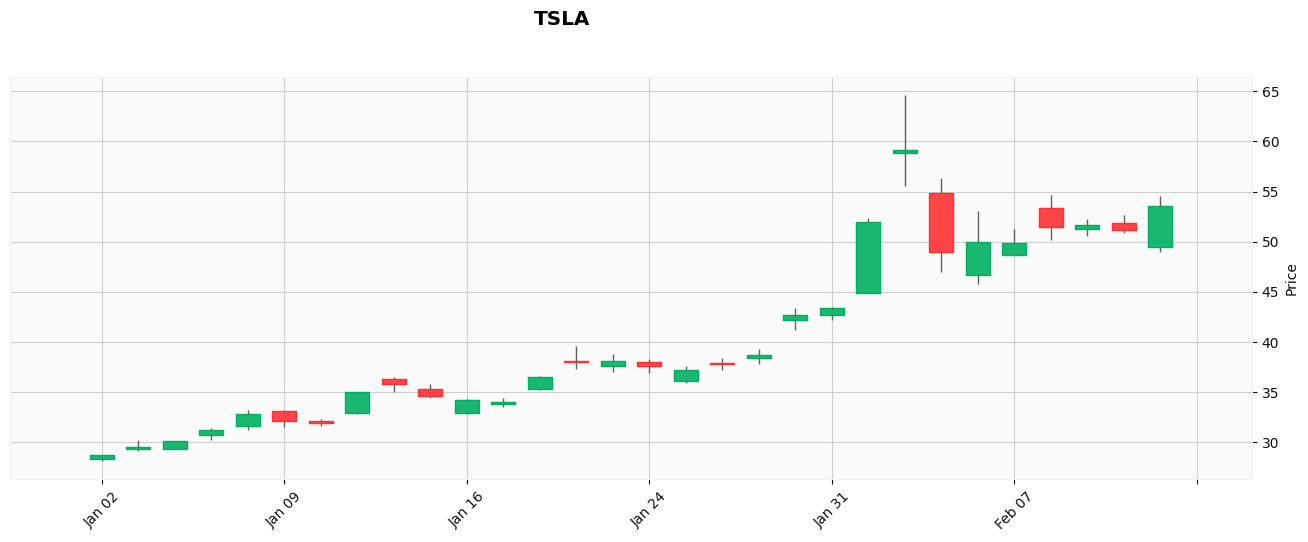

In [4]:
# 繪製K線圖
color_up  = "red"
color_down = "green"

tsla_df_example = tsla_df.iloc[:30]

mpf.plot(
    tsla_df_example,
    type="candle",
    style="yahoo",
    title="TSLA",
    ylabel="Price",
    figratio=(18, 6),
    
)

In [5]:
# 用bokeh繪製可互動的k線圖
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource
import pandas as pd

output_notebook()  # 讓圖顯示在 Jupyter Notebook

df = tsla_df[:30].copy()  # 保險用

source = ColumnDataSource(df)

# 設定 K 線顏色
inc = df.Close > df.Open
dec = df.Close < df.Open

p = figure(
    x_axis_type="datetime",
    width=900,
    height=450,
    title="TSLA Interactive Candlestick Chart",
    tools="pan,wheel_zoom,box_zoom,reset,save",
)

# 畫 K 線柱（最高-最低）
p.segment('Date', 'High', 'Date', 'Low', source=source, color="black")

# 畫向上 K 線（紅色）
p.vbar(df.index[inc], width=12*60*60*1000,  # 半天毫秒
       top=df.Close[inc], bottom=df.Open[inc],
       fill_color="red", line_color="red")

# 畫向下 K 線（綠色）
p.vbar(df.index[dec], width=12*60*60*1000,
       top=df.Open[dec], bottom=df.Close[dec],
       fill_color="green", line_color="green")

p.xaxis.axis_label = "Date"
p.yaxis.axis_label = "Price"

show(p)


Loading BokehJS ...

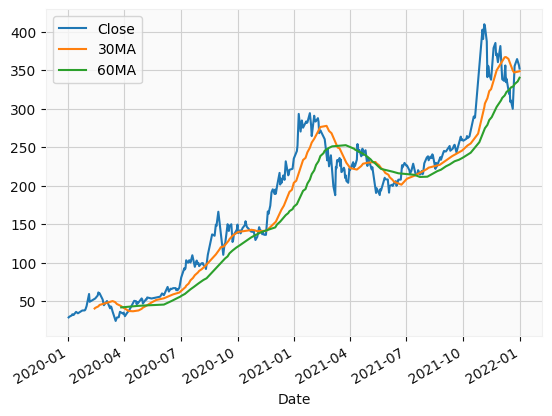

In [6]:
tsla_df.Close.plot()

# 30日平均移動線
tsla_df.Close.rolling(window=30).mean().plot()

# 60日 
tsla_df.Close.rolling(window=60).mean().plot()

plt.legend(['Close', '30MA', '60MA'], loc='best')

In [7]:
# seaborn 在 matpllotlib 上封裝了更高級的 API，使作圖更容易與美觀
# 更多實用的方法再自己練習吧
import seaborn as sns


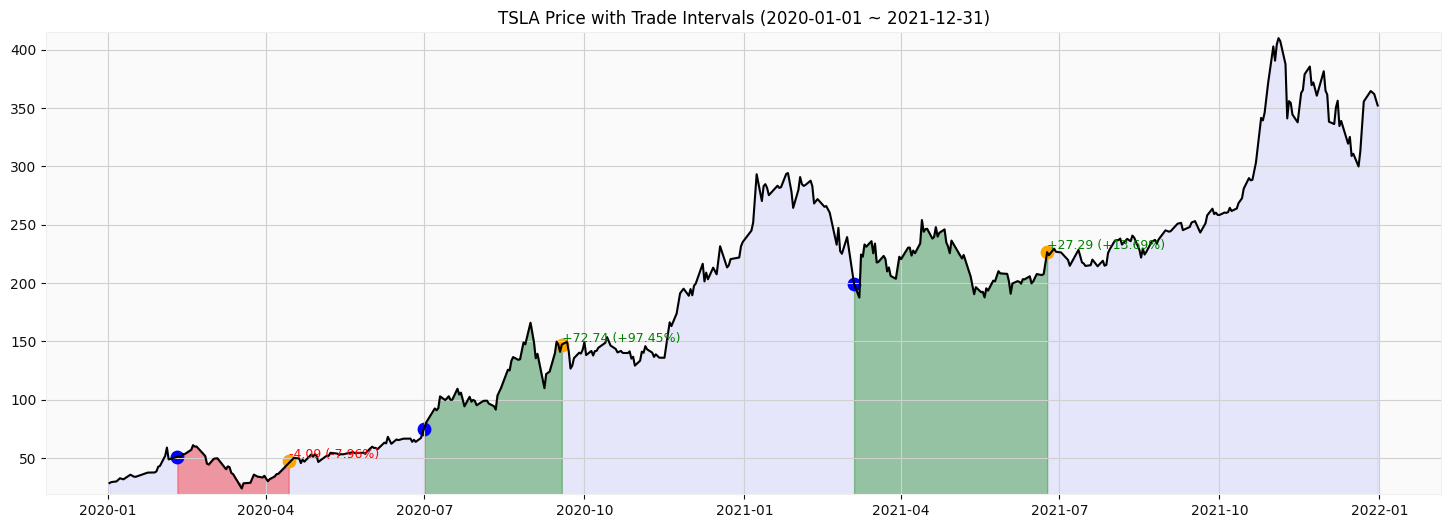

In [8]:
# 標示策略交易區間：假設執行一個量化交易策略，例如2020-05-01買入、2020-12-31賣出
# 初始化 + 畫基底線圖（只呼叫一次）
def plot_base(df, start='2020-01-01', end='2021-12-31'):
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)

    sub = df.loc[start:end]

    plt.figure(figsize=(18, 6))
    plt.plot(sub.index, sub['Close'], color='black', label='Close')
    plt.fill_between(sub.index, 0, sub['Close'], color='blue', alpha=0.08)
    plt.title(f"TSLA Price with Trade Intervals ({start.date()} ~ {end.date()})")
    plt.ylim(sub['Close'].min() - 5, sub['Close'].max() + 5)

# 在同一張圖上疊加交易區間
def annotate_trade(df, buy_date, sell_date):
    # 找最近交易日
    buy_date = df.index.asof(pd.to_datetime(buy_date))
    sell_date = df.index.asof(pd.to_datetime(sell_date))

    buy_price = df.loc[buy_date, 'Close']
    sell_price = df.loc[sell_date, 'Close']

    pnl = sell_price - buy_price
    pnl_rate = pnl / buy_price * 100
    color = "green" if pnl > 0 else "red"

    # ✅ 正確區間遮罩（不會產生 IndexError）
    mask = (df.index >= buy_date) & (df.index <= sell_date)

    # 標示持有區間背景
    plt.fill_between(df.index[mask], 0, df['Close'][mask], color=color, alpha=0.35)

    # 買入與賣出標點
    plt.scatter(buy_date, buy_price, color='blue', s=80)
    plt.scatter(sell_date, sell_price, color='orange', s=80)

    # 盈虧文字提示
    plt.text(sell_date, sell_price,
             f"{pnl:+.2f} ({pnl_rate:+.2f}%)",
             color=color,
             fontsize=9,
             ha='left',
             va='bottom')

plot_base(tsla_df, '2020-01-01', '2021-12-31')

annotate_trade(tsla_df, '2020-02-10', '2020-04-14')
annotate_trade(tsla_df, '2020-07-01', '2020-09-18')
annotate_trade(tsla_df, '2021-03-05', '2021-06-24')

plt.show()

## 🧩 1. MACD 指標原理簡介

**MACD（Moving Average Convergence Divergence，平滑異同移動平均線）**  
是一種用來觀察 **股價趨勢與動能變化** 的技術指標，  
由 Gerald Appel 在 1970 年代提出。

---

### ⚙️ 計算方式

1. **DIF（快線）** = EMA(12) − EMA(26)  
   > 分別計算 12 日與 26 日的指數移動平均（EMA），取其差值。

2. **DEA（慢線 / 信號線）** = DIF 的 9 日 EMA  
   > 對 DIF 進一步平滑，作為趨勢信號線。

3. **BAR（柱狀圖）** = 2 × (DIF − DEA)  
   > 反映多空力量差距，常以紅綠柱顯示趨勢強弱。

---

### 📈 指標意義

| 現象 | 趨勢解讀 | 操作訊號 |
|------|-----------|-----------|
| DIF 上穿 DEA | 多頭趨勢啟動 | 💹 買入訊號 |
| DIF 下穿 DEA | 空頭趨勢啟動 | 🔻 賣出訊號 |
| BAR 柱放大 | 趨勢加速（動能增強） | 趨勢延續 |
| BAR 柱縮小 | 趨勢減弱或即將反轉 | 謹慎觀察 |

---

### 💡 小結

- **MACD 可用於判斷趨勢方向與轉折時機。**  
- **快線（DIF）反應較敏銳，慢線（DEA）較平滑穩定。**  
- **柱狀圖（BAR）** 是觀察動能變化的直觀輔助工具。


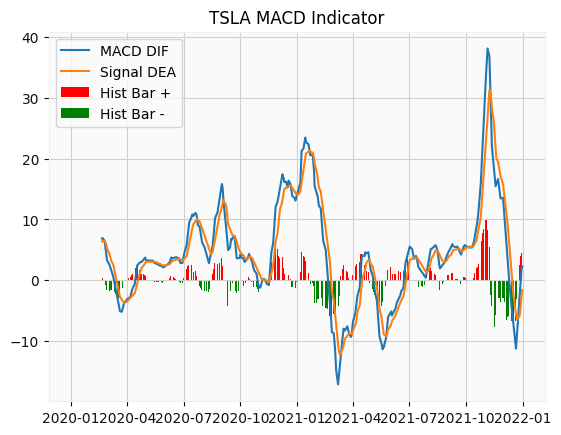

In [9]:
# 技術指標可視化
import talib
import numpy as np

# 假設 tsla_df 是 Tesla 股價資料（DataFrame）
kl_index = tsla_df.index

# ⚠️ talib.MACD 參數需為 NumPy 陣列
dif, dea, bar = talib.MACD(
    tsla_df.Close.values,   # 收盤價序列
    fastperiod=12,          # 快速 EMA 週期
    slowperiod=26,          # 慢速 EMA 週期
    signalperiod=9          # DEA 平滑週期
)

# 畫出 DIF（快線）與 DEA（慢線）
plt.plot(kl_index, dif, label='MACD DIF')
plt.plot(kl_index, dea, label='Signal DEA')

# 將柱狀圖分成紅（上漲）與綠（下跌）
bar_red = np.where(bar > 0, bar, 0)
bar_green = np.where(bar < 0, bar, 0)

# 畫出紅色與綠色的柱狀圖
plt.bar(kl_index, bar_red, color='red', label='Hist Bar +')
plt.bar(kl_index, bar_green, color='green', label='Hist Bar -')

# 加上圖例
plt.legend(loc='best')
plt.title('TSLA MACD Indicator')
plt.show()

## 🧩 ATR 的定義與計算方式

**ATR（Average True Range，平均真實波幅）** 是用來衡量市場波動性的技術指標，  
由技術分析大師 **J. Welles Wilder** 於 1978 年提出。  
它反映的是價格波動的「幅度大小」，而非方向（漲或跌）。

---

### 🔢 真實波幅（True Range, TR）

ATR 的計算基於「真實波幅（TR）」而來。  
對於每一個交易日，**TR 定義為以下三者中的最大值：**

1. 當日最高價 − 當日最低價  
2. |當日最高價 − 昨日收盤價|  
3. |當日最低價 − 昨日收盤價|

> 取三者中的最大值，可以反映市場真實波動範圍，  
> 包括跳空開盤或劇烈震盪等情況。

---

### 🧮 平均真實波幅（Average True Range, ATR）

**ATR 是 TR 的移動平均值**，常用的時間週期為 14 日或 21 日。  
例如：

- ATR(14)：過去 **14 天** TR 的平均值  
- ATR(21)：過去 **21 天** TR 的平均值  

這樣可以平滑掉短期的異常波動，使指標更穩定。

---

### 📈 意義說明

- **ATR 高 → 波動大**（市場情緒強烈、波動劇烈）  
- **ATR 低 → 波動小**（市場平靜、整理盤整）

---

### 💡 小結

| 名稱 | 說明 | 代表意義 |
|------|------|-----------|
| TR | 真實波幅 | 當天真實的價格波動範圍 |
| ATR | 平均真實波幅 | 一段時間內的平均波動性 |
| ATR(14) | 14 日平均真實波幅 | 常用於中期趨勢觀察 |
| ATR(21) | 21 日平均真實波幅 | 更長週期，波動更平滑 |


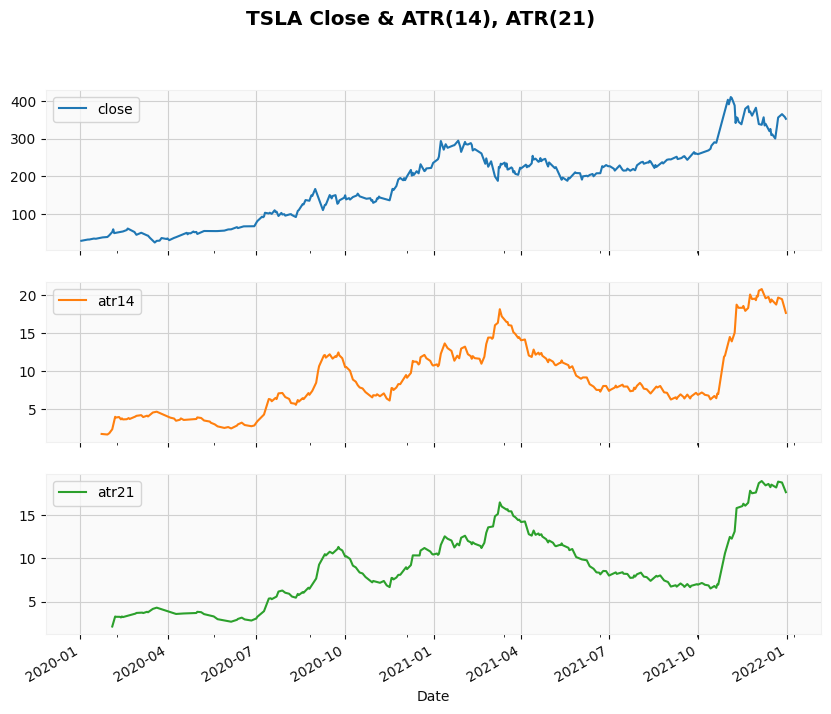

In [10]:
# 假設 tsla_df 是包含 Tesla 股票資料的 DataFrame
# 必須包含欄位：'high', 'low', 'close'
# 例如：
# tsla_df = pd.read_csv('TSLA.csv')

# 計算 ATR(14)
atr14 = talib.ATR(
    tsla_df['High'].values,
    tsla_df['Low'].values,
    tsla_df['Close'].values,
    timeperiod=14
)

# 計算 ATR(21)
atr21 = talib.ATR(
    tsla_df['High'].values,
    tsla_df['Low'].values,
    tsla_df['Close'].values,
    timeperiod=21
)

# 建立新的 DataFrame 以便繪圖
atr_df = pd.DataFrame({
    'close': tsla_df['Close'],
    'atr14': atr14,
    'atr21': atr21
})

# 使用 plot() 函數繪製子圖
atr_df.plot(subplots=True, grid=True, figsize=(10, 8))
plt.suptitle('TSLA Close & ATR(14), ATR(21)')
plt.show()
